In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

USE_CUDA = False

In [3]:
from nalgene.generate import *

parsed = parse_file('.', 'grammar.nlg')
parsed.map_leaves(tokenizeLeaf)

In [4]:
def descend(node, fn, child_type='phrase', returns=None):
    if returns is None: returns = []
    returned = fn(node)
    returns.append(returned)

    for child in node.children:
        if (child_type is None) or (child.type == child_type):
            descend(child, fn, child_type, returns)
    
    return returns

In [5]:
def ascend(node, fn):
    if node.parent is None:
        return fn(node)
    else:
        return ascend(node.parent, fn)

## Building input and output vocabularies

To find all input vocabulary tokens, we can traverse the parsed nalgene tree and copy all `word` type tokens.

**TODO**: Use GloVe vectors for input vocabulary

In [6]:
input_tokens = []

def get_input_tokens(node):
    if node.type == 'word':
        input_tokens.append(node.key)

descend(parsed, get_input_tokens, None)

input_tokens = list(set(input_tokens))
input_tokens = ['EOS'] + input_tokens
print(input_tokens)

['EOS', '1', 'Feel', 'days', 'get', 'Tonight', 'Blonde', 'Just', 'de', 'Melody', 'Such', '3', ':', 'Sunny', 'Moves', 'Bon', 'Dogulu', 'white', 'am', 'if', 'Radio', 'Boogie', 'Mono', 'Nev', 'thank', 'from', 'Hate', 'thanks', 'Back', 'Our', 'Cure', 'Gathering', 'All', 'Japanese', 'yo', 'state', 'For', 'Theme', 'Where', 'could', 'plx', 'some', 'basement', 'Take', 'Soul', 'green', 'Dream', 'People', 'when', 'Sheriff', 'Baby', 'Seven', 'Let', 'Did', 'Maroon', 'Funky', 'to', 'Darkness', 'Athena', 'light', 'Any', 'soon', '5', 'there', 'White', 'pot', 'Louie', "what's", 'eth', 'down', 'Way', 'blue', 'minutes', 'Kenan', 'Afternoon', 'Of', 'Agua', 'Rappers', 'Elsiane', 'I', 'Breeze', 'Sex', 'make', 'On', 'Black', 'Berlin', 'Somebody', 'In', 'Town', 'Massive', 'bitcoin', 'high', 'Dry', 'Best', 'Delilah', 'Remaster', 'yen', 'orange', 'Big', 'Will', 'Sesen', 'Be', '6', 'Day', 'Ceza', 'Sympathy', 'Voodoo', 'Reha', 'then', 'Annique', 'room', 'equal', 'Naive', 'Me', 'very', 'as', 'Great', 'please', 'l

For output tokens, we can just take the top level node names that are either phrases or variables.

In [7]:
output_tokens = [child.key for child in parsed.children if child.type in ['phrase', 'variable']]
output_tokens = ['EOS'] + output_tokens
print(output_tokens)

['EOS', '%', '%if', '%timer', '%command', '%sequence', '%time', '%relative_time', '%absolute_time', '%condition', '%checkValue', '%getNumberValue', '%getValue', '%action', '%checkLightState', '%checkSwitchState', '%getLightState', '%getSwitchState', '%getTemperature', '%getPrice', '%setLightState', '%light_state', '%setSwitchState', '%setTemperature', '%setVolume', '%playMusic', '$operator', '$asset', '$room', '$light', '$switch', '$on_off', '$up_down', '$color', '$number', '$_number', '$time_unit', '$time', '$artist', '$song']


## Getting input and target data for nodes

In [8]:
def words_for_position(words, position):
    if position is None:
        return words
    start, end, length = position
    return words[start : end + 1]

In [9]:
def relative_position(node, parent):
    if parent.position is None:
        return node.position
    return node.position[0] - parent.position[0], node.position[1] - parent.position[0], node.position[2]

In [10]:
def data_for_node(flat, node):
    words = [child.key for child in flat.children]
    inputs = words_for_position(words, node.position)
    keys = [child.key for child in node.children]
    positions = [relative_position(child, node) for child in node.children]
    return node.key, inputs, list(zip(keys, positions))

In [11]:
walked_flat, walked_tree = walk_tree(parsed, parsed['%'], None)
data_for_node(walked_flat, walked_tree.children[0])

('%timer',
 ['in',
  '6',
  '9',
  'minutes',
  'turn',
  'off',
  'the',
  'bedroom',
  'light',
  'next',
  'could',
  'you',
  'make',
  'the',
  'volume',
  'up'],
 [('%relative_time', (0, 3, 4)), ('%sequence', (4, 15, 12))])

## Creating tensors for input and target data

In [12]:
def tokens_to_tensor(tokens, source_tokens, append_eos=True):
    indexes = []
    for token in tokens:
        indexes.append(source_tokens.index(token))
    if append_eos:
        indexes.append(0)
    return torch.LongTensor(indexes)

In [13]:
def ranges_to_tensor(ranges, seq_len):
    ranges_tensor = torch.zeros(len(ranges), seq_len)
    for r in range(len(ranges)):
        start, end, _ = ranges[r]
        ranges_tensor[r, start:end+1] = 1
    return ranges_tensor

ranges_to_tensor([(0, 2, 3), (4, 4, 1)], 5)


 1  1  1  0  0
 0  0  0  0  1
[torch.FloatTensor of size 2x5]

## Model

The core model is a regular seq2seq/encoder-decoder model with attention. The attention model is from [Luong et al.'s "Effective Approaches to Attention-based Neural Machine Translation"](https://arxiv.org/abs/1508.04025) using dot-product based attention energies.

The encoder and decoder take one additional input `context` which represents the phrase parent we are currently operating on, e.g. `%setLightState`. At the top level node the context is always `%`.

The encoder encodes the input sequence into a series of vectors using a bidirectional GRU. The decoder "translates" this into a sequence of phrase tokens, given the encoder outputs and current context, e.g. "turn off the office light" + `%setLightState` &rarr; `[$on_off, $light]`.

The last piece of the model is the Pointer, which is run for each decoded token, given the decoder's hidden state at that point. The pointer's goal is to select which of the input words are relevant to the decoded token, e.g. `$light` &rarr; "office light". The idea is similar to a [Vinyals et al.'s Pointer Network](https://arxiv.org/abs/1506.03134) but chooses one or more outputs rather than just one.

Once the decoder and pointer have chosen tokens and alignments, the phrase tokens and corresponding "pointed at" sub-inputs are used as the context and inputs of the next iteration. This recurs until no more phrase tokens are decoded.

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=True)

    def forward(self, context_input, word_inputs):
        # TODO: Incorporate context input
        # TODO: Batching
        
        seq_len = word_inputs.size(0)
        batch_size = word_inputs.size(1)
        
        embedded = self.embedding(word_inputs.view(seq_len * batch_size, -1)) # Process seq x batch at once
        output = embedded.view(seq_len, batch_size, -1) # Resize back to seq x batch for RNN

        outputs, hidden = self.gru(output)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs

        return outputs, hidden

In [15]:
class DotAttn(nn.Module):
    def __init__(self):
        super(DotAttn, self).__init__()

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = hidden.dot(encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)

In [16]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout=0.05):
        super(Decoder, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        self.attn = DotAttn()
    
    def forward(self, context_input, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: Batching
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine context and embedded word, through RNN
        rnn_input = torch.cat((context_input.unsqueeze(0), word_embedded), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

The Pointer network is a recurrent neural network with an embedding, a single-layer GRU, and linear output layer with a sigmoid transformation. The hidden state is initialized with the decoder's latest hidden state, replicated to fit the bidirectional GRU.

In [17]:
class Pointer(nn.Module):
    def __init__(self, hidden_size, dropout=0.05):
        super(Pointer, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, dropout=dropout)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, context, decoder_hidden, encoder_outputs):
        # Combine encoder outputs with context
#         print('[pointer] context', context.size())
#         print('[pointer] encoder_outputs', encoder_outputs.size())
        context = context.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
#         print('[pointer] expanded context', context.size())
        combined_outputs = torch.cat((encoder_outputs, context), 2)
        
        # Run combined sequence through encoder
        hidden = decoder_hidden.repeat(2, 1, 1) # Repeat decoder's single-directional hidden state for bidirectional GRU
        outputs, hidden = self.gru(combined_outputs, hidden)
        # Sum bidirectional outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        
        # Make final 0-1 prediction
        outputs = self.out(outputs.squeeze(1))
        outputs = F.sigmoid(outputs)

        return outputs

We can turn the whole thing into one module by combining the Encoder, Decoder, and Pointer networks. There's also an embedding layer for the context tokens, which includes the overall context (used by the encoder and decoder) and pointer context (based on the last output of the decoder).

In [18]:
MAX_LENGTH = 50

class RARNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RARNN, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)
        self.pointer = Pointer(hidden_size)

    def forward(self, context_input, word_inputs, word_targets=None):
        # Get embedding for context input
        context_embedded = self.embedding(context_input)
        
        input_len = word_inputs.size(0)
        target_len = word_targets.size(0) if word_targets is not None else MAX_LENGTH
        
        # Run through encoder
        encoder_outputs, encoder_hidden = self.encoder(context_embedded, word_inputs)
        decoder_hidden = encoder_hidden # Use encoder's last hidden state
        decoder_input = Variable(torch.LongTensor([0])) # EOS/SOS token
        if USE_CUDA:
            decoder_input = decoder_input.cuda()

        # Variables to store decoder and pointer outputs
        decoder_outputs = Variable(torch.zeros(target_len, output_size))
        pointer_outputs = Variable(torch.zeros(target_len - 1, input_len)) # Pointer never runs on EOS
        if USE_CUDA:
            decoder_outputs = decoder_outputs.cuda()
            pointer_outputs = pointer_outputs.cuda()
        
        # Run through decoder and pointer
        for i in range(target_len):
            decoder_output, decoder_hidden, decoder_attn = self.decoder(context_embedded, decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[i] = decoder_output
    
            # Teacher forcing with known targets, if provided
            if word_targets is not None:
                decoder_input = word_targets[i]
                decoder_input_embedded = self.embedding(decoder_input) # Context for pointer

                if i < target_len - 1:
                    pointer_output = self.pointer(decoder_input_embedded, decoder_hidden, encoder_outputs)
                    pointer_outputs[i] = pointer_output

            # Sample with last outputs
            else:
                max_index = decoder_output.topk(1)[1].data[0][0]
                decoder_input = Variable(torch.LongTensor([max_index]))
                if USE_CUDA:
                    decoder_input = decoder_input.cuda()
                decoder_input_embedded = self.embedding(decoder_input) # Context for pointer

                if max_index == 0: # EOS
                    break
                else:
                    pointer_output = self.pointer(decoder_input_embedded, decoder_hidden, encoder_outputs)
                    pointer_outputs[i] = pointer_output
        
        # Slice outputs
        if word_targets is None:
            decoder_outputs = decoder_outputs[:i]
            pointer_outputs = pointer_outputs[:i-1]

        return decoder_outputs, pointer_outputs

## Training

The inputs to the network are the current phrase label, e.g. `%getLightState` and the string to parse, "the living room light is on". The outputs are the child node labels, `$light` and `$on_off` with a selection of words given by attention-like weights over the sequence, treated as boolean values given a threshold.

In [19]:
input_size = len(input_tokens)
output_size = len(output_tokens)
hidden_size = 100

learning_rate = 1e-4
weight_decay = 1e-6

rarnn = RARNN(input_size, output_size, hidden_size)
optimizer = torch.optim.Adam(rarnn.parameters(), lr=learning_rate, weight_decay=weight_decay)

decoder_criterion = nn.NLLLoss()
pointer_criterion = nn.MSELoss(size_average=False)

In [20]:
def train(flat, node):
    context, inputs, targets = data_for_node(flat, node)

    # Turn inputs into tensors
    context_var = tokens_to_tensor([context], output_tokens, False)
    context_var = Variable(context_var)
    inputs_var = tokens_to_tensor(inputs, input_tokens).view(-1, 1, 1) # seq x batch x size
    inputs_var = Variable(inputs_var)
    target_tokens = [target_token for target_token, _ in targets]
    target_ranges = [target_range for _, target_range in targets]
    target_tokens_var = tokens_to_tensor(target_tokens, output_tokens)
    target_tokens_var = Variable(target_tokens_var)
    target_ranges_var = ranges_to_tensor(target_ranges, len(inputs) + 1)
    target_ranges_var = Variable(target_ranges_var)
 
    # Run through model
    decoder_outputs, pointer_outputs = rarnn(context_var, inputs_var, target_tokens_var)

    # Loss calculation and backprop
    optimizer.zero_grad()
    decoder_loss = decoder_criterion(decoder_outputs, target_tokens_var)
    pointer_loss = pointer_criterion(pointer_outputs, target_ranges_var)
    total_loss = decoder_loss + pointer_loss
    total_loss.backward()
    optimizer.step()

    return total_loss.data[0]

In [21]:
import sconce
job = sconce.Job('rarnn')
job.plot_every = 20
job.log_every = 100

n_epochs = 5000

for i in range(n_epochs):
    walked_flat, walked_tree = walk_tree(parsed, parsed['%'], None)
    def _train(node): return train(walked_flat, node)
    ds = descend(walked_tree, _train)
    d = sum(ds) / len(ds)
    job.record(i, d)

Starting job 593f4520f8e1c2083c22b2ad at 2017-06-12 18:51:28
[log] 0m 40s (100) 3.7317
[log] 1m 19s (200) 2.4530
[log] 2m 2s (300) 1.4793
[log] 2m 50s (400) 0.6257
[log] 3m 45s (500) 0.6116
[log] 4m 32s (600) 0.7344
[log] 5m 29s (700) 0.4152
[log] 6m 21s (800) 0.3565
[log] 7m 19s (900) 0.2362
[log] 8m 10s (1000) 0.1185
[log] 9m 5s (1100) 0.3738
[log] 9m 58s (1200) 0.4474
[log] 10m 45s (1300) 0.3026
[log] 11m 29s (1400) 0.1411
[log] 12m 11s (1500) 0.1635
[log] 13m 1s (1600) 0.1979
[log] 13m 49s (1700) 0.2851
[log] 14m 37s (1800) 0.1623
[log] 15m 30s (1900) 0.0988
[log] 16m 20s (2000) 0.0397
[log] 17m 13s (2100) 0.1279
[log] 18m 9s (2200) 0.0429
[log] 19m 3s (2300) 0.0343
[log] 19m 59s (2400) 0.0534
[log] 20m 51s (2500) 0.0298
[log] 21m 42s (2600) 0.0471
[log] 22m 34s (2700) 0.0357
[log] 23m 20s (2800) 0.0180
[log] 24m 12s (2900) 0.0529
[log] 25m 4s (3000) 0.0754
[log] 25m 52s (3100) 0.0492
[log] 26m 46s (3200) 0.0563
[log] 27m 33s (3300) 0.0211
[log] 28m 19s (3400) 0.1325
[log] 29m 7s (

## Evaluating

In [30]:
def evaluate(context, inputs, node=None):
    if node == None:
        node = Node('parsed')
    
    # Turn data into tensors
    context_var = tokens_to_tensor([context], output_tokens, False)
    context_var = Variable(context_var)
    inputs_var = tokens_to_tensor(inputs, input_tokens).view(-1, 1, 1) # seq x batch x size
    inputs_var = Variable(inputs_var)
    
    # Run through RARNN
    decoder_outputs, pointer_outputs = rarnn(context_var, inputs_var)
    
    # Given the decoder and pointer outputs, gather contexts and inputs for sub-phrases
    # Use pointer values > 0.5 to select words for next input sequence

    next_contexts = []
    next_inputs = []
    
    for i in range(len(decoder_outputs)):
        max_value, max_index = decoder_outputs[i].topk(1)
        max_index = max_index.data[0]
        next_contexts.append(output_tokens[max_index]) # Get decoder output token
        p = pointer_outputs[i]
        next_input = []
        for j in range(len(p) - 1):
            pj = p[j].data[0]
            if pj > 0.5:
                next_input.append(inputs[j])
        next_inputs.append(next_input)

    evaluated = list(zip(next_contexts, next_inputs))

    # Print decoded outputs
    print('\n(evaluate) %s %s -> %s' % (context, inputs, next_contexts))
    
    # Plot pointer outputs
    fig = plt.figure(figsize=(len(inputs) / 3, 99))
    sub = fig.add_subplot(111)
    sub.matshow(pointer_outputs.data.squeeze(1).numpy(), vmin=0, vmax=1, cmap='hot')
    plt.show(); plt.close()
    
    for context, inputs in evaluated:
        # Add a node for parsed sub-phrases and values
        sub_node = Node(context)
        node.add(sub_node)
        
        # Recursively evaluate sub-phrases
        if context[0] == '%':
            evaluate(context, inputs, sub_node)
    
        # Or add words directly to value node
        elif context[0] == '$':
            sub_node.add(' '.join(inputs))

    return node

In [31]:
def evaluate_and_print(context, inputs):
    evaluated = evaluate(context, inputs)
    print(' '.join(inputs))
    print(evaluated)

['heya', 'if', 'the', 'coffee', 'pot', 'is', 'on', 'then', 'play', 'shit', 'by', 'Muse', 'then', 'pls', 'change', 'the', 'tea', 'on', 'thank', 'you', 'very', 'much'] ( %
    ( %if (1, 17, 17)
        ( %condition (2, 6, 5)
            ( %checkSwitchState (2, 6, 5)
                ( $switch (3, 4, 2) coffee pot )
                ( $on_off (6, 6, 1) on ) ) )
        ( %sequence (8, 17, 10)
            ( %action (8, 11, 4)
                ( %playMusic (8, 11, 4)
                    ( $artist (11, 11, 1) Muse ) ) )
            ( %action (14, 17, 4)
                ( %setSwitchState (14, 17, 4)
                    ( $switch (16, 16, 1) tea )
                    ( $on_off (17, 17, 1) on ) ) ) ) ) )

(evaluate) % ['heya', 'if', 'the', 'coffee', 'pot', 'is', 'on', 'then', 'play', 'shit', 'by', 'Muse', 'then', 'pls', 'change', 'the', 'tea', 'on', 'thank', 'you', 'very', 'much'] -> ['%if']


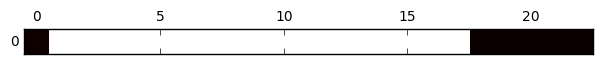


(evaluate) %if ['if', 'the', 'coffee', 'pot', 'is', 'on', 'then', 'play', 'shit', 'by', 'Muse', 'then', 'pls', 'change', 'the', 'tea', 'on'] -> ['%condition', '%action']


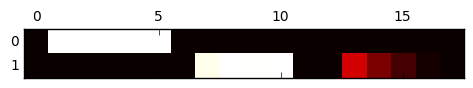


(evaluate) %condition ['the', 'coffee', 'pot', 'is', 'on'] -> ['%checkSwitchState']


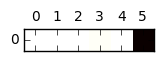


(evaluate) %checkSwitchState ['the', 'coffee', 'pot', 'is', 'on'] -> ['$switch', '$on_off']


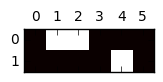


(evaluate) %action ['play', 'shit', 'by', 'Muse'] -> ['%playMusic']


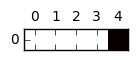


(evaluate) %playMusic ['play', 'shit', 'by', 'Muse'] -> ['$artist']


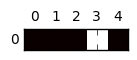

heya if the coffee pot is on then play shit by Muse then pls change the tea on thank you very much
( parsed
    ( %if
        ( %condition
            ( %checkSwitchState
                ( $switch coffee pot )
                ( $on_off on ) ) )
        ( %action
            ( %playMusic
                ( $artist Muse ) ) ) ) )


In [32]:
walked_flat, walked_tree = walk_tree(parsed, parsed['%'], None)
inputs = [child.key for child in walked_flat.children]
print(inputs, walked_tree)
evaluate_and_print('%', inputs)


(evaluate) % ['hey', 'maia', 'if', 'the', 'ethereum', 'price', 'is', 'less', 'than', '2', '0', 'then', 'turn', 'the', 'living', 'room', 'light', 'on'] -> ['%if']


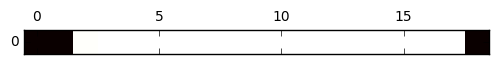


(evaluate) %if ['if', 'the', 'ethereum', 'price', 'is', 'less', 'than', '2', '0', 'then', 'turn', 'the', 'living', 'room', 'light', 'on'] -> ['%condition', '%action']


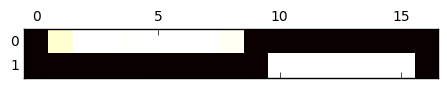


(evaluate) %condition ['the', 'ethereum', 'price', 'is', 'less', 'than', '2', '0'] -> ['%getPrice', '$operator', '$number']


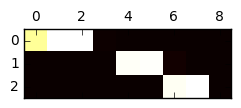


(evaluate) %getPrice ['the', 'ethereum', 'price'] -> ['$asset']


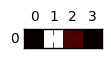


(evaluate) %action ['turn', 'the', 'living', 'room', 'light', 'on'] -> ['%setLightState']


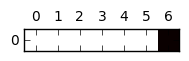


(evaluate) %setLightState ['turn', 'the', 'living', 'room', 'light', 'on'] -> ['$light', '$on_off']


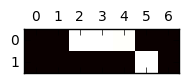

hey maia if the ethereum price is less than 2 0 then turn the living room light on
( parsed
    ( %if
        ( %condition
            ( %getPrice
                ( $asset ethereum ) )
            ( $operator less than )
            ( $number 2 0 ) )
        ( %action
            ( %setLightState
                ( $light living room light )
                ( $on_off on ) ) ) ) )


In [25]:
evaluate_and_print('%', "hey maia if the ethereum price is less than 2 0 then turn the living room light on".split(' '))


(evaluate) % ['hey', 'maia', "what's", 'the', 'ethereum', 'price'] -> ['%action']


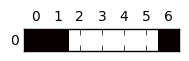


(evaluate) %action ["what's", 'the', 'ethereum', 'price'] -> ['%getPrice']


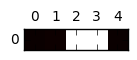


(evaluate) %getPrice ['ethereum', 'price'] -> ['$asset']


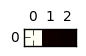

hey maia what's the ethereum price
( parsed
    ( %action
        ( %getPrice
            ( $asset ethereum ) ) ) )


In [26]:
evaluate_and_print('%', "hey maia what's the ethereum price".split(' '))


(evaluate) % ['hey', 'maia', 'play', 'some', 'Skrillex', 'please', 'and', 'then', 'turn', 'the', 'office', 'light', 'off'] -> ['%sequence']


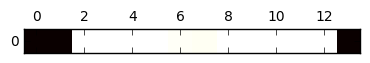


(evaluate) %sequence ['play', 'some', 'Skrillex', 'please', 'and', 'then', 'turn', 'the', 'office', 'light', 'off'] -> ['%action', '%action', '%action']


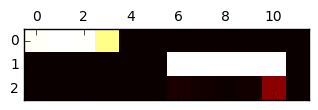


(evaluate) %action ['play', 'some', 'Skrillex', 'please'] -> ['%playMusic']


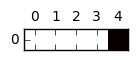


(evaluate) %playMusic ['play', 'some', 'Skrillex', 'please'] -> ['$artist']


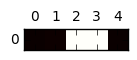


(evaluate) %action ['turn', 'the', 'office', 'light', 'off'] -> ['%setLightState']


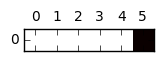


(evaluate) %setLightState ['turn', 'the', 'office', 'light', 'off'] -> ['$light', '$on_off']


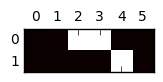

ValueError: result of slicing is an empty tensor

In [27]:
evaluate_and_print('%', "hey maia play some Skrillex please and then turn the office light off".split(' '))


(evaluate) % ['turn', 'the', 'office', 'light', 'up', 'and', 'also', 'could', 'you', 'please', 'turn', 'off', 'the', 'living', 'room', 'light', 'and', 'make', 'the', 'temperature', 'of', 'the', 'bedroom', 'to', '6', 'thank', 'you', 'maia'] -> ['%sequence']


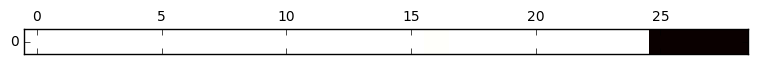


(evaluate) %sequence ['turn', 'the', 'office', 'light', 'up', 'and', 'also', 'could', 'you', 'please', 'turn', 'off', 'the', 'living', 'room', 'light', 'and', 'make', 'the', 'temperature', 'of', 'the', 'bedroom', 'to', '6'] -> ['%action', '%action', '%action']


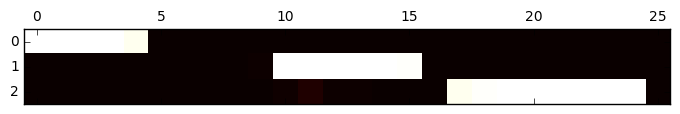


(evaluate) %action ['turn', 'the', 'office', 'light', 'up'] -> ['%setLightState']


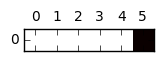


(evaluate) %setLightState ['turn', 'the', 'office', 'light', 'up'] -> ['$light', '$up_down']


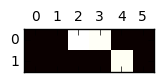


(evaluate) %action ['turn', 'off', 'the', 'living', 'room', 'light'] -> ['%setLightState']


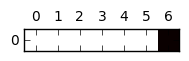


(evaluate) %setLightState ['turn', 'off', 'the', 'living', 'room', 'light'] -> ['$on_off', '$light']


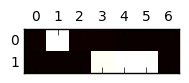


(evaluate) %action ['make', 'the', 'temperature', 'of', 'the', 'bedroom', 'to', '6'] -> ['%setTemperature']


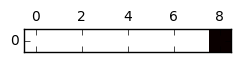


(evaluate) %setTemperature ['make', 'the', 'temperature', 'of', 'the', 'bedroom', 'to', '6'] -> ['$room', '$number']


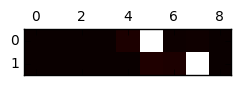

turn the office light up and also could you please turn off the living room light and make the temperature of the bedroom to 6 thank you maia
( parsed
    ( %sequence
        ( %action
            ( %setLightState
                ( $light office light )
                ( $up_down up ) ) )
        ( %action
            ( %setLightState
                ( $on_off off )
                ( $light living room light ) ) )
        ( %action
            ( %setTemperature
                ( $room bedroom )
                ( $number 6 ) ) ) ) )


In [28]:
evaluate_and_print('%', "turn the office light up and also could you please turn off the living room light and make the temperature of the bedroom to 6 thank you maia".split(' '))


(evaluate) % ['turn', 'the', 'living', 'room', 'light', 'off', 'and', 'turn', 'the', 'bedroom', 'light', 'up', 'and', 'also', 'turn', 'the', 'volume', 'up'] -> ['%sequence']


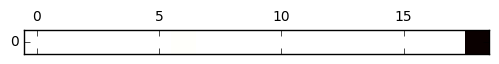


(evaluate) %sequence ['turn', 'the', 'living', 'room', 'light', 'off', 'and', 'turn', 'the', 'bedroom', 'light', 'up', 'and', 'also', 'turn', 'the', 'volume', 'up'] -> ['%action', '%action', '%action']


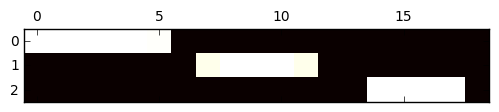


(evaluate) %action ['turn', 'the', 'living', 'room', 'light', 'off'] -> ['%setLightState']


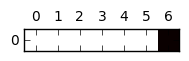


(evaluate) %setLightState ['turn', 'the', 'living', 'room', 'light', 'off'] -> ['$light', '$on_off']


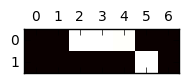


(evaluate) %action ['turn', 'the', 'bedroom', 'light', 'up'] -> ['%setLightState']


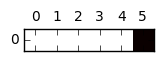


(evaluate) %setLightState ['turn', 'the', 'bedroom', 'light', 'up'] -> ['$light', '$up_down']


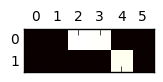


(evaluate) %action ['turn', 'the', 'volume', 'up'] -> ['%setVolume']


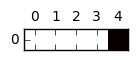


(evaluate) %setVolume ['turn', 'the', 'volume', 'up'] -> ['$up_down']


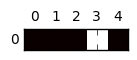

turn the living room light off and turn the bedroom light up and also turn the volume up
( parsed
    ( %sequence
        ( %action
            ( %setLightState
                ( $light living room light )
                ( $on_off off ) ) )
        ( %action
            ( %setLightState
                ( $light bedroom light )
                ( $up_down up ) ) )
        ( %action
            ( %setVolume
                ( $up_down up ) ) ) ) )


In [29]:
evaluate_and_print('%', "turn the living room light off and turn the bedroom light up and also turn the volume up".split(' '))